In [197]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import xgboost as xgb
from matplotlib.colors import LinearSegmentedColormap
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from pygam import LinearGAM, s, f
import sklearn
from joblib import dump, load
import joblib

In [ ]:
# Load the dataset
malaria_df = pd.read_csv('C:/Users/Mrman/pypboi/Malaria_temp_prec_pop.csv')

In [ ]:
# removal of potential whitespace in the 'Malaria_case_count' column
malaria_df['Malaria_case_count'] = malaria_df['Malaria_case_count'].str.replace(' ', '')

In [4]:
# Convert 'malaria_case_count' column to integer
malaria_df['Malaria_case_count'] = pd.to_numeric(malaria_df['Malaria_case_count'], errors='coerce')

# Check the data type of the column
print(malaria_df['Malaria_case_count'].dtype)

# Check for any NaN values introduced during the conversion
print(malaria_df['Malaria_case_count'].isnull().sum())

int64
0


## Feature creation

In [ ]:
# create malaria cases per 100k people
malaria_df['Malaria_per_100k'] = (malaria_df['Malaria_case_count'] / malaria_df['Population']) * 100000

In [ ]:
# feature engineering for log transformations and polynomial features
malaria_df['log_cases_per_100k'] = np.log1p(malaria_df['Malaria_per_100k'])  # log1p avoids issues with zeros
malaria_df['log_population'] = np.log1p(malaria_df['Population'])
malaria_df['temperature_squared'] = malaria_df['Avg_Temp'] ** 2
malaria_df['log_precipitation'] = np.log1p(malaria_df['Annual_precipitation'])

In [7]:
# assign x and y variables
X = malaria_df[['Avg_Temp', 'Annual_precipitation', 'Population']] #predictor
X_nopop = malaria_df[['Avg_Temp', 'Annual_precipitation']] #predictor without population
y = malaria_df['log_cases_per_100k'] #target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# training data without population
X_train_nopop, X_test_nopop, y_train_nopop, y_test_nopop = train_test_split(X_nopop, y, test_size=0.2, random_state=42)

## Determining best fit model

In [8]:
# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, 
                      cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
rf_grid.fit(X_train_nopop, y_train_nopop)

# Get the best model and evaluate it
rf_best_model = rf_grid.best_estimator_
rf_y_pred = rf_best_model.predict(X_test_nopop)
rf_mse = mean_squared_error(y_test_nopop, rf_y_pred)
rf_r2 = r2_score(y_test_nopop, rf_y_pred)

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Random Forest MSE: {rf_mse}")
print(f"Best Random Forest R²: {rf_r2}")

# Ridge Regression
ridge_param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'fit_intercept': [True, False],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg']
}

ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid,
                         cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Get the best model and evaluate it
ridge_best_model = ridge_grid.best_estimator_
ridge_y_pred = ridge_best_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)

print(f"Best Ridge parameters: {ridge_grid.best_params_}")
print(f"Best Ridge MSE: {ridge_mse}")
print(f"Best Ridge R²: {ridge_r2}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest MSE: 4.843593766183411
Best Random Forest R²: 0.641923722751006
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best Ridge parameters: {'alpha': 100.0, 'fit_intercept': True, 'solver': 'cholesky'}
Best Ridge MSE: 9.371071899737645
Best Ridge R²: 0.3072171817714635


In [9]:
# variance of y_test to compare against MSE
print(f"Variance of y_test: {y_test.var()}")

Variance of y_test: 13.603565761834163


## Training Model

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=300,  # Number of trees
    max_depth=30,    # Maximum depth of trees 
    min_samples_split=2,  # Minimum samples required to split a node
    min_samples_leaf=1,   # Minimum samples required at each leaf node
    max_features='sqrt',  # Number of features to consider for best split
    random_state=42       # For reproducibility
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)


In [ ]:
# obtain mse and r2 for both train and test sets
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# print the results
print(f"Training MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

Training MSE: 0.351
Test MSE: 1.885
Training R²: 0.974
Test R²: 0.861


In [12]:
# variance of y_test to compare against MSE
print(f"Variance of y_test: {y_test.var()}")

Variance of y_test: 13.603565761834163


In [19]:
# Save the Random Forest model to a file
dump(rf_model, "malaria_randomforest_model.joblib")
print("Model saved as malaria_randomforest_model.joblib")

Model saved as malaria_randomforest_model.joblib


## Model Evaluation

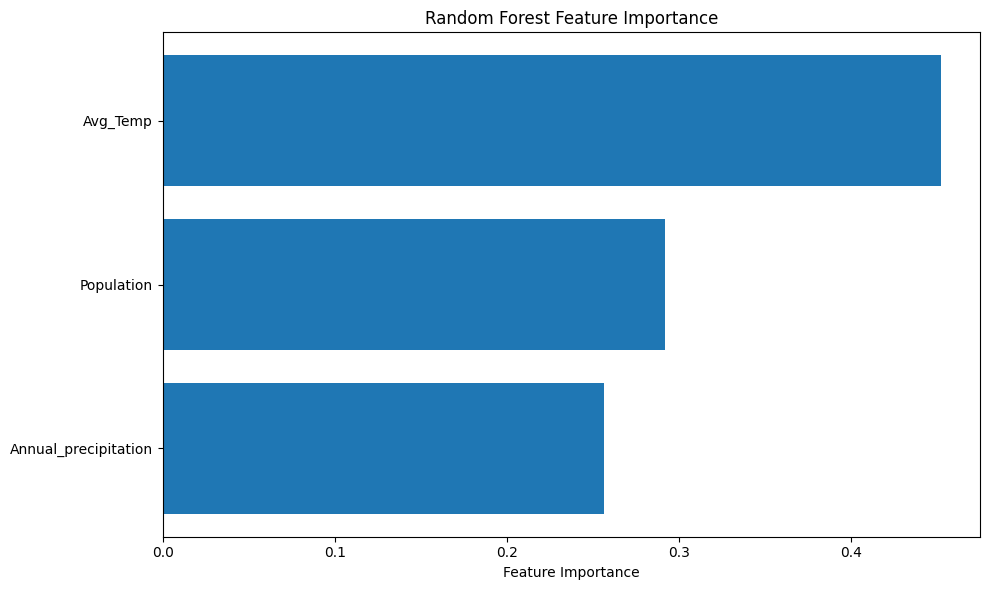

In [ ]:
# Evaluation of feature importance
# Feature importance plot
feature_importance = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

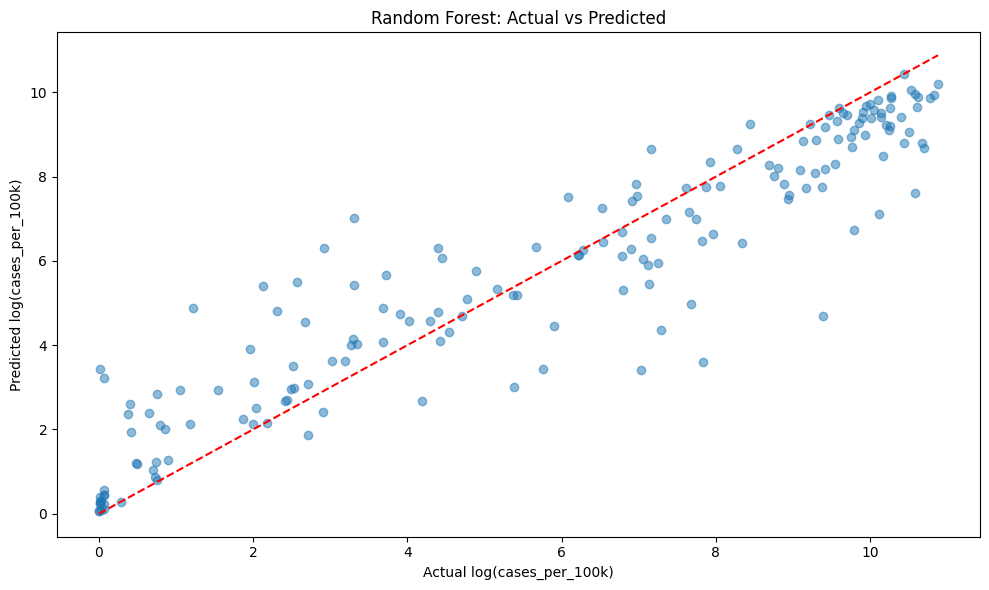

In [16]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual log(cases_per_100k)')
plt.ylabel('Predicted log(cases_per_100k)')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()

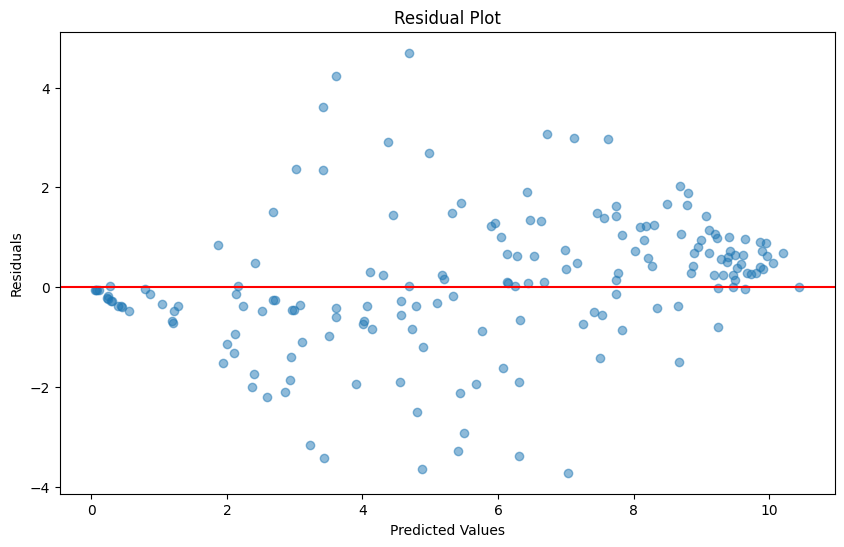

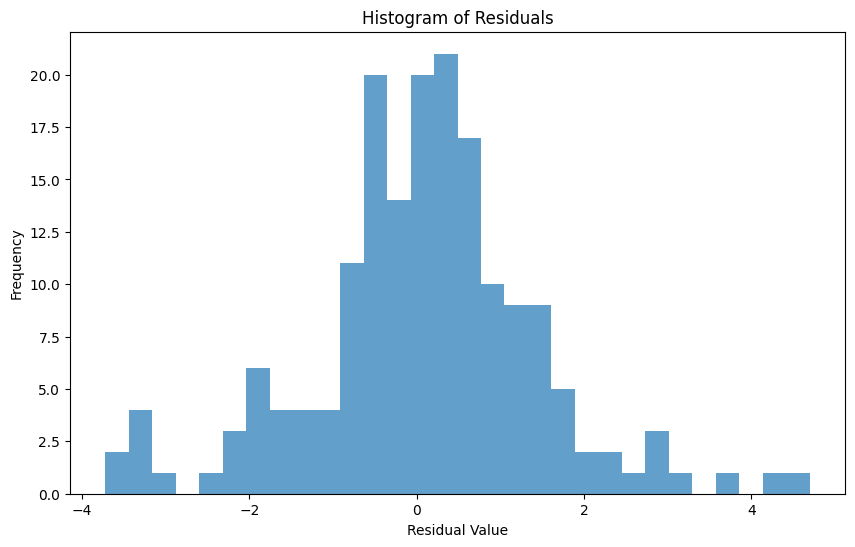

In [17]:
# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
# input api key
API_KEY = "****************"  # Replace with your actual API key
# Ensure you have the correct API key and permissions to access the WeatherStack API

# List of unique country names from your malaria dataset
locations = malaria_df['Country'].dropna().unique().tolist()

# Initialize an empty list to store results
weather_records = []

for country in locations:
    url = f"http://api.weatherstack.com/current"
    params = {
        "access_key": API_KEY,
        "query": country
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Check if the response contains weather data
    if data.get("current") and data.get("location"):
        weather_records.append({
            "Country": data["location"]["country"],
            "Current_Temperature_C": data["current"]["temperature"]
        })
    else:
        print(f"Could not fetch data for {country} — response: {data.get('error', 'No error info')}")

# Convert the list of records into a DataFrame
weather_df = pd.DataFrame(weather_records)

# Display the results
print(weather_df.head(100))


Could not fetch data for Eswatini — response: {'code': 615, 'type': 'request_failed', 'info': 'Your API request failed. Please try again or contact support.'}
Could not fetch data for Türkiye — response: {'code': 615, 'type': 'request_failed', 'info': 'Your API request failed. Please try again or contact support.'}
                        Country  Current_Temperature_C
0                      Paraguay                     23
1                         Sudan                     32
2      Central African Republic                     23
3                   Philippines                     20
4  USA United States of America                     20


In [194]:
map_merge = malaria_df.merge(weather_df, on="Country", how="left")
#map_merge["Current_Temperature_C"] = map_merge["Current_Temperature_C"].fillna(map_merge["Avg_Temp"])

print(map_merge.head(100))

   Code                           Country  Year  Malaria_case_count  \
0   PRY                          Paraguay  2023                   0   
1   SDN                             Sudan  2023             1304528   
2   CAF          Central African Republic  2023             1979614   
3   IRN        Iran (Islamic Republic of)  2023               10004   
4   BOL  Bolivia (Plurinational State of)  2023               10297   
..  ...                               ...   ...                 ...   
95  PNG                  Papua New Guinea  2023              952886   
96  ZAF                      South Africa  2023                9890   
97  LBR                           Liberia  2023              994782   
98  BLZ                            Belize  2022                   0   
99  AZE                        Azerbaijan  2022                   1   

                Country_temp   Avg_Temp              Country_prec  \
0                   Paraguay  25.322174                  Paraguay   
1        

In [179]:
filtered_map_merge = map_merge.dropna(subset=['Current_Temperature_C'])
filtered_map_merge.drop(columns=['Avg_Temp'], inplace=True, errors='ignore')
filtered_map_merge.rename(columns={'Current_Temperature_C':'Avg_Temp'}, inplace=True)

In [ ]:
rf_model = joblib.load("C:/Users/Mrman/pypboi/malaria_randomforest_model.joblib")

# assign features for prediction
features = filtered_map_merge[["Avg_Temp", "Annual_precipitation", "Population"]]

# Predict log malaria rate and then exponentiate to get back to per 100k scale
filtered_map_merge["Predicted_Malaria_per_100k"] = np.exp(rf_model.predict(features))

# Show top predictions
print(filtered_map_merge[["Country", "Predicted_Malaria_per_100k"]].head(30))

In [198]:
world = gpd.read_file(r"c:\Users\Mrman\Downloads\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp")

In [199]:
# Replace country names in the world GeoDataFrame with those in the malaria DataFrame
world.loc[world["ADMIN"] == "Ivory Coast", "ADMIN"] = "Cote d'Ivoire"
world.loc[world["ADMIN"] == "Republic of the Congo", "ADMIN"] = "Congo"
world.loc[world["ADMIN"] == "Guyane", "ADMIN"] = "French Guiana"
world.loc[world["ADMIN"] == "Bolivia", "ADMIN"] = "Bolivia (Plurinational State of)"
world.loc[world["ADMIN"] == "Venezuela", "ADMIN"] = "Venezuela (Bolivarian Republic of)"
world.loc[world["ADMIN"] == "Iran", "ADMIN"] = "Iran (Islamic Republic of)"
world.loc[world["ADMIN"] == "North Korea", "ADMIN"] = "Democratic People's Republic of Korea"
world.loc[world["ADMIN"] == "Turkey", "ADMIN"] = "Türkiye"
world.loc[world["ADMIN"] == "Vietnam", "ADMIN"] = "Viet Nam"
world.loc[world["ADMIN"] == "East Timor", "ADMIN"] = "Timor-Leste"

In [ ]:
# Merge the filtered map merge DataFrame with the world GeoDataFrame
world = world.merge(filtered_map_merge, left_on="ADMIN", right_on="Country", how="left")
world['Predicted_Malaria_per_100k'] = world['Predicted_Malaria_per_100k'].fillna(0)

In [204]:
bins = [0, 100, 5000, 10000, np.inf]  # bins to categorize the malaria risk
labels = ['Low', 'Moderate', 'High', 'Very High']

world['malaria_risk'] = pd.cut(world['Predicted_Malaria_per_100k'], bins=bins, labels=labels)


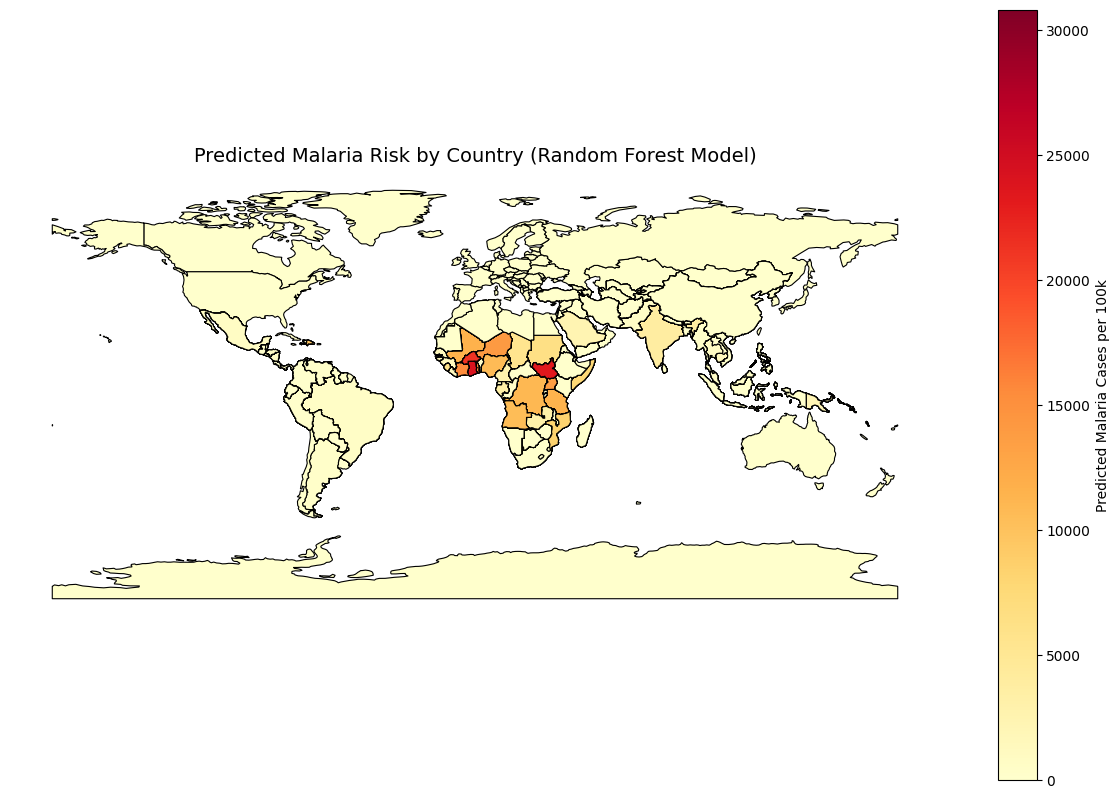

In [202]:
# Create map of predicted malaria risk
# Set up the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map, using malaria predictions for color scaling
world.plot(column='Predicted_Malaria_per_100k', cmap='YlOrRd', linewidth=0.8, edgecolor='black',
           legend=True, legend_kwds={'label': "Predicted Malaria Cases per 100k"}, ax=ax)
plt.axis("off")

# Add title
plt.title("Predicted Malaria Risk by Country (Random Forest Model)", fontsize=14)

# Show the map
plt.show()

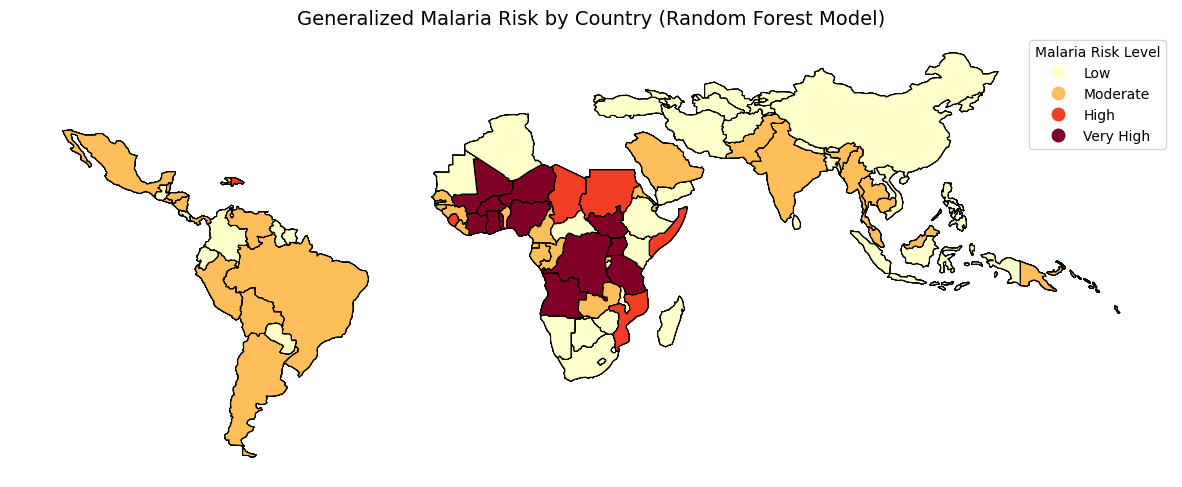

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot map with malaria risk levels
world.plot(column='malaria_risk', cmap='YlOrRd', linewidth=0.8, edgecolor='black',
           legend=True, legend_kwds={'title': "Malaria Risk Level"}, ax=ax)

plt.axis("off")
plt.title("Generalized Malaria Risk by Country (Random Forest Model)", fontsize=14)
plt.show()
